<font size=7>Прогнозирование кредитных рисков</font>

<br>

Задача: 
 - построить модель машинного обучения для предсказания является ли кредит, 
предоставленный человеку, хорошим или плохим риском.

Решение и выбор метрики:
 - Решение сводится к бинарной классификации
 - Важным моментом для задачи является минимизация случаев, когда модель выдает положительный риск, который на самом деле является отрицательным. То есть критическим значением является FalsePositive, потому что не так страшно не выдать кредит, когда он потенциально хороший, чем выдать кредит, когда он потенциально плохой (но модель оценивает его положительно). 
 - Получается нам важно контролировать метрики Precision, Recall и F1 именно по 0-му классу. Но при этом также нужно контролировать показатели по 1-му классу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
data = pd.read_csv('data/training.csv')
data.head()

checking_status  duration                    credit_history  \
0   'no checking'        18  'critical/other existing credit'   
1            '<0'        24                   'existing paid'   
2   'no checking'        36             'no credits/all paid'   
3   'no checking'        15                   'existing paid'   
4            '<0'        21                   'existing paid'   

               purpose  credit_amount savings_status employment  \
0             radio/tv           1800         '<100'   '1<=X<4'   
1             radio/tv           2439         '<100'       '<1'   
2              repairs           2613         '<100'   '1<=X<4'   
3            education           4623   '100<=X<500'   '1<=X<4'   
4  furniture/equipment           3599         '<100'   '4<=X<7'   

   installment_commitment       personal_status other_parties  ...  \
0                       4         'male single'          none  ...   
1                       4  'female div/dep/mar'          none  ...   
2                       4         'male single'          none  ...   
3                       3         'male single'          none  ...   
4                       1  'female div/dep/mar'          none  ...   

   property_magnitude age  other_payment_plans housing existing_credits  \
0                 car  24                 none     own                2   
1       'real estate'  35                 none     own                1   
2                 car  27                 none     own                2   
3    'life insurance'  40                 none     own                1   
4                 car  26                 none    rent                1   

                           job num_dependents  own_telephone foreign_worker  \
0                      skilled              1           none            yes   
1                      skilled              1            yes            yes   
2                      skilled              1           none            yes   
3  'high qualif/self emp/mgmt'              1            yes            yes   
4         'unskilled resident'              1           none            yes   

  class  
0  good  
1   bad  
2  good  
3   bad  
4  good  

[5 rows x 21 columns]

In [3]:
categorical_columns = data.select_dtypes('object')
for col in categorical_columns:
    data[col] = data[col].map(lambda x: x.replace("'", ""))

<font size=6>Exploratory Data Analysis</font>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         800 non-null    object
 1   duration                800 non-null    int64 
 2   credit_history          800 non-null    object
 3   purpose                 800 non-null    object
 4   credit_amount           800 non-null    int64 
 5   savings_status          800 non-null    object
 6   employment              800 non-null    object
 7   installment_commitment  800 non-null    int64 
 8   personal_status         800 non-null    object
 9   other_parties           800 non-null    object
 10  residence_since         800 non-null    int64 
 11  property_magnitude      800 non-null    object
 12  age                     800 non-null    int64 
 13  other_payment_plans     800 non-null    object
 14  housing                 800 non-null    object
 15  existi

Немного оптимизируем датасет по памяти

In [5]:
data['own_telephone'] = data['own_telephone'].map(lambda x: 1 if x == 'yes' else 0)
data['foreign_worker'] = data['foreign_worker'].map(lambda x: 1 if x == 'yes' else 0)
data['class'] = data['class'].map(lambda x: 1 if x == 'good' else 0)

In [6]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.to_list()
numeric_cols += ['own_telephone', 'foreign_worker', 'class']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], downcast='unsigned')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         800 non-null    object
 1   duration                800 non-null    uint8 
 2   credit_history          800 non-null    object
 3   purpose                 800 non-null    object
 4   credit_amount           800 non-null    uint16
 5   savings_status          800 non-null    object
 6   employment              800 non-null    object
 7   installment_commitment  800 non-null    uint8 
 8   personal_status         800 non-null    object
 9   other_parties           800 non-null    object
 10  residence_since         800 non-null    uint8 
 11  property_magnitude      800 non-null    object
 12  age                     800 non-null    uint8 
 13  other_payment_plans     800 non-null    object
 14  housing                 800 non-null    object
 15  existi

<font size=5>Распределение <b>целевой переменной</b></font>

In [8]:
target_values = data['class'].value_counts()

colors = ['#4E79A7', '#F28E2B', '#E15759']
fig = go.Figure(data=[go.Pie(labels=target_values.index, values=target_values.values, 
                             marker=dict(colors=colors))])

fig.update_layout(
    title='Распределение целевой переменной',
    width=700,
    height=500,
    template='plotly_dark',
)

fig.show()

 - 30% Кредитов оказались в классе плохих рисков
 - Дисбаланс в таргете и малое количество данных в выборке (800 случаев) - эти два показателя в дальнейшем могут сыграть плохую роль в обнаружении 0-го класса


<font size=5>Распределение <b>признаков</b></font>

In [9]:
data.describe()

duration  credit_amount  installment_commitment  residence_since  \
count  800.000000     800.000000              800.000000       800.000000   
mean    21.031250    3337.878750                2.945000         2.878750   
std     12.171502    2866.828413                1.118498         1.092264   
min      4.000000     250.000000                1.000000         1.000000   
25%     12.000000    1364.000000                2.000000         2.000000   
50%     18.000000    2332.000000                3.000000         3.000000   
75%     24.000000    4166.000000                4.000000         4.000000   
max     60.000000   18424.000000                4.000000         4.000000   

              age  existing_credits  num_dependents  own_telephone  \
count  800.000000        800.000000      800.000000     800.000000   
mean    35.631250          1.410000        1.142500       0.405000   
std     11.757682          0.574293        0.349781       0.491199   
min     19.000000          1.000000        1.000000       0.000000   
25%     26.000000          1.000000        1.000000       0.000000   
50%     33.000000          1.000000        1.000000       0.000000   
75%     42.000000          2.000000        1.000000       1.000000   
max     75.000000          4.000000        2.000000       1.000000   

       foreign_worker       class  
count      800.000000  800.000000  
mean         0.965000    0.700000  
std          0.183895    0.458544  
min          0.000000    0.000000  
25%          1.000000    0.000000  
50%          1.000000    1.000000  
75%          1.000000    1.000000  
max          1.000000    1.000000

In [10]:
data.loc[:, ['duration', 'credit_amount', 'age', 'class']].groupby('class').describe()

duration                                                     \
         count       mean        std  min   25%   50%   75%   max   
class                                                               
0        240.0  24.841667  13.241557  6.0  12.0  24.0  36.0  60.0   
1        560.0  19.398214  11.308347  4.0  12.0  18.0  24.0  60.0   

      credit_amount               ...                      age             \
              count         mean  ...      75%      max  count       mean   
class                             ...                                       
0             240.0  3968.691667  ...  5104.25  18424.0  240.0  34.137500   
1             560.0  3067.530357  ...  3788.00  15857.0  560.0  36.271429   

                                                 
             std   min   25%   50%    75%   max  
class                                            
0      11.861908  19.0  25.0  30.0  40.25  74.0  
1      11.664875  19.0  27.0  34.0  43.00  75.0  

[2 rows x 24 columns]

Если рассматривать статистические показатели каждого из классов,
то <b>duration</b> и <b>age</b> у обоих примерно одинаковый, а вот <b>credit_amount</b> отличается

In [11]:
num_cols1 = ['duration', 'credit_amount', 'age']

In [41]:
def calculate_bin_size(data: pd.DataFrame) -> float:
    """
    Функция для нахождения размера бина
    :param data: набор данных
    :return: размер бина
    """
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_size = 2 * iqr * len(data) ** (-1 / 3)
    return bin_size


def get_distplot(data_plot: pd.DataFrame, cols: list) -> None:
    """
    Функция для построения distplot
    :param data_plot: набор данных;
    :param cols: список с признаками;
    :return: None
    """
    for feature in cols:
        hist_data = [
            data_plot[data_plot['class'] == 0][feature],
            data_plot[data_plot['class'] == 1][feature]
        ]
        group_labels = ['Class 0', 'Class 1']

        bin_size_0 = calculate_bin_size(hist_data[0])
        bin_size_1 = calculate_bin_size(hist_data[1])
        bin_size = min(bin_size_0, bin_size_1)

        try:
            fig = ff.create_distplot(hist_data, group_labels, show_rug=False, bin_size=bin_size)
            fig.update_layout(
                title=f'Distribution of {feature} by Class',
                width=800,
                height=500,
                template='plotly_dark',
            )
            fig.show()
        except TypeError:
            print(f'Ошибка с {feature}')

In [42]:
get_distplot(data_plot=data, cols=num_cols1)

Распределения признаков каждого класса примерно одинаковые и скошены вправо

In [43]:
categorical_columns = data.select_dtypes(include=['object']).columns

def plot_dashboard(data, columns: list, rows: int, cols: int, figsize: tuple[int, int]) -> None:
    """
    Функция показывает распределения признаков относительно классов 0 и 1.
    График показывает сколько раз то или иное значение в признаке относилось 
    к 1 или 0, при этом учитывая дисбаланс между 0 и 1. 
    Таким образом, мы можем увидеть к какому классу больше относится то или иное значение 
    :param data: набор данных;
    :param columns: список признаков;
    :param rows: кол-во графиков по строкам;
    :param cols: кол-во графиков по столбцам;
    :param figsize: размер дашборда;
    :return: None
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, feature in enumerate(columns):
        ct = pd.crosstab(data[feature], data['class'], normalize='columns')

        ax = ct.plot(kind='bar', stacked=True, ax=axes[i])

        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height:.2f}', (x + width / 2, y + height / 2),
                        ha='center', va='center')

        ax.set_title(f'{feature} vs Target (normalized)')
        ax.set_ylabel('Proportion')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

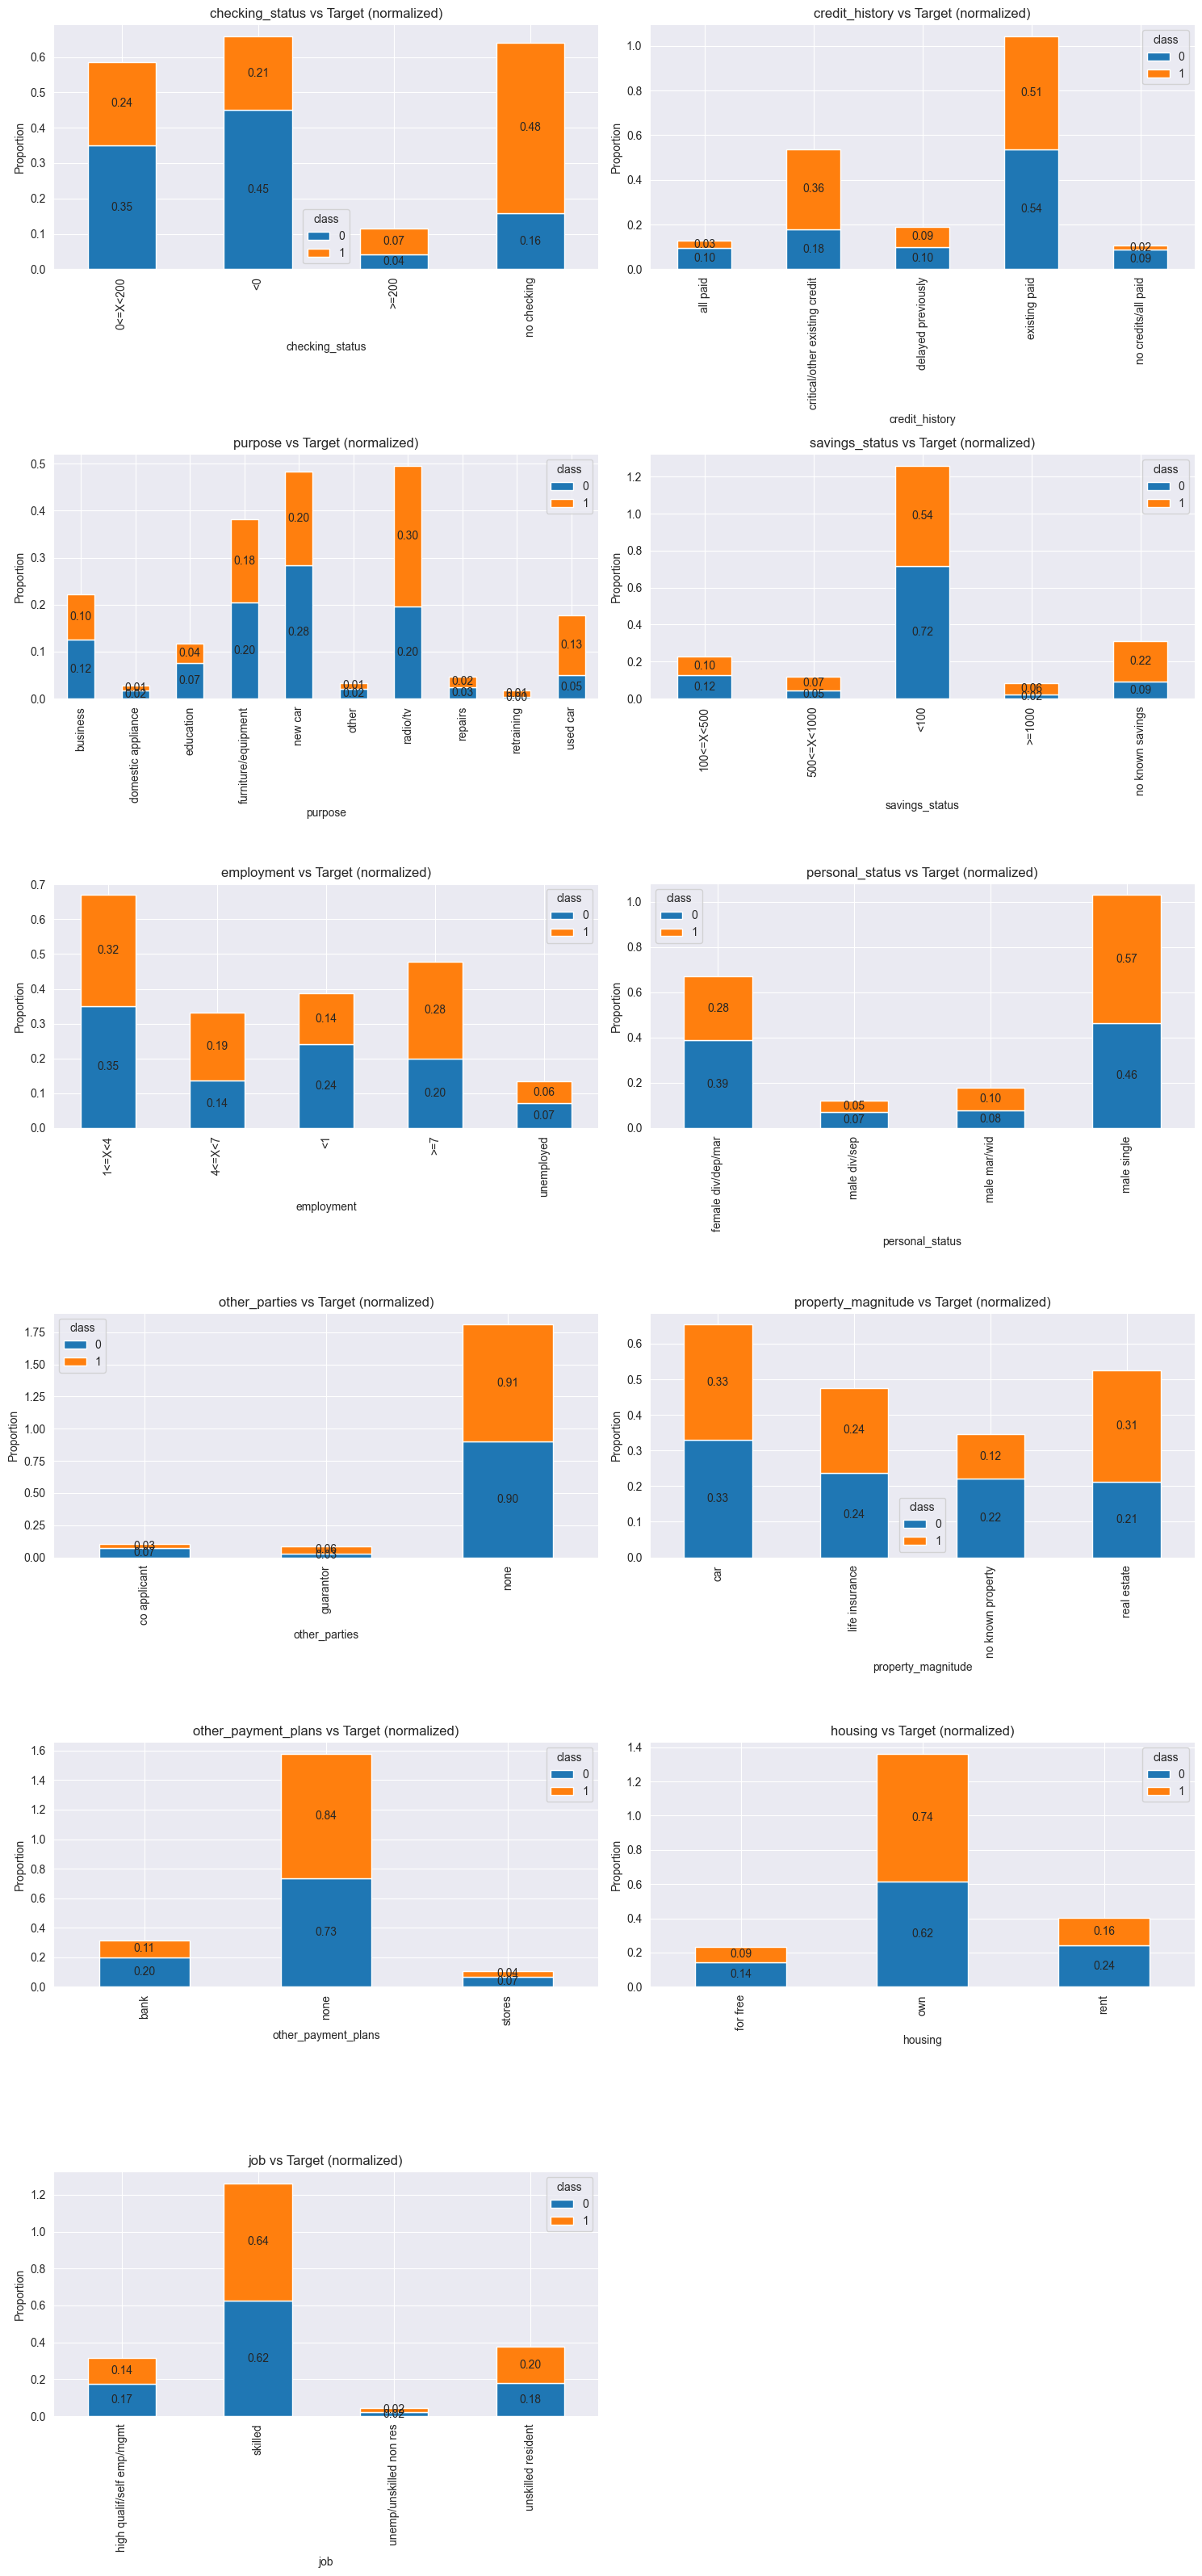

In [15]:
 plot_dashboard(data=data, columns=categorical_columns, rows=6, cols=2, figsize=(15, 32))

<font size=4>Анализ дашборда:</font>

 - <b>checking_status</b>: класс 0 явно преобладает в значениях "<0" и "0<=X<200", класс 1 преобладает в значение "no checking", который указывает на отсутствие счета в банке. Доверять этому значению, по-моему, немного опасно, ведь если мы будем считать "нового клиента" всегда потенциально хорошим риском, то это может привести к ошибкам. Больше надежности дает информация о том, что человек уже является клиентом банка, и мы можем проверить его счет. Поэтому попробуем создать дополнительную фичу - low_status, которая будет говорить о том, что у клиента низкий счет в банке;
  - <b>credit_history</b>: должен оказывать влияние на риск, поэтому оставляем этот признак;
  - <b>purpose</b>: цель кредита не сильно влияет на таргет, потенциально можем считать этот признак "неважным";
  - <b>savings_status</b>: в значение "<100" преобладает класс 0. Можем создать фичу "low_savings" - которая будет показывать у каких клиентов сбережения < 100;
  - <b>employment</b>: примерно равен для обоих классов. Его в дальнейшем попробуем закодировать через OrdinalEncoding;
  - <b>personal_status</b>: попробуем оставить как есть;
  - <b>other_parties</b>: Из-за того, что категория none доминирует, сравнение между классами становится практически невозможным. Можно преобразовать признак в бинарный: none (0) против всех остальных (co applicant и guarantor = 1)
  - <b>property_magnitude</b>: оставим как есть
  - <b>other_payment_plans</b>: Имеет похожее распределение на other_parties, поэтому логика обработки будет такая же.
  - <b>housing</b>: по логике должен быть важным признаком, поэтому попробуем оставить его;
  - <b>job</b>: этот признак также попробуем оставить.

In [16]:
def is_status_low(x: str) -> int:
    if x == '<0' or x == '0<=X<200':
        return 1
    return 0

def is_saving_low(x: str) -> int:
    if x == '<100' or x == '100<=X<500':
        return 1
    return 0

def employment_code(x: str) -> int:
    code = {
        'unemployed': 0,
        '<1': 1,
        '1<=X<4': 2,
        '4<=X<7': 3,
        '>=7': 4
    }
    try:
        return code[x]
    except KeyError:
        return x


data['low_status'] = data['checking_status'].map(is_status_low).astype('uint8')
data['low_savings'] = data['savings_status'].map(is_saving_low).astype('uint8')
data['employment'] = data['employment'].map(employment_code).astype('uint8')
data['other_parties'] = data['other_parties'].map(lambda x: 0 if x == 'none' else 1).astype('uint8')
data['other_payment_plans'] = data['other_payment_plans'].map(lambda x: 0 if x == 'none' else 1).astype('uint8')

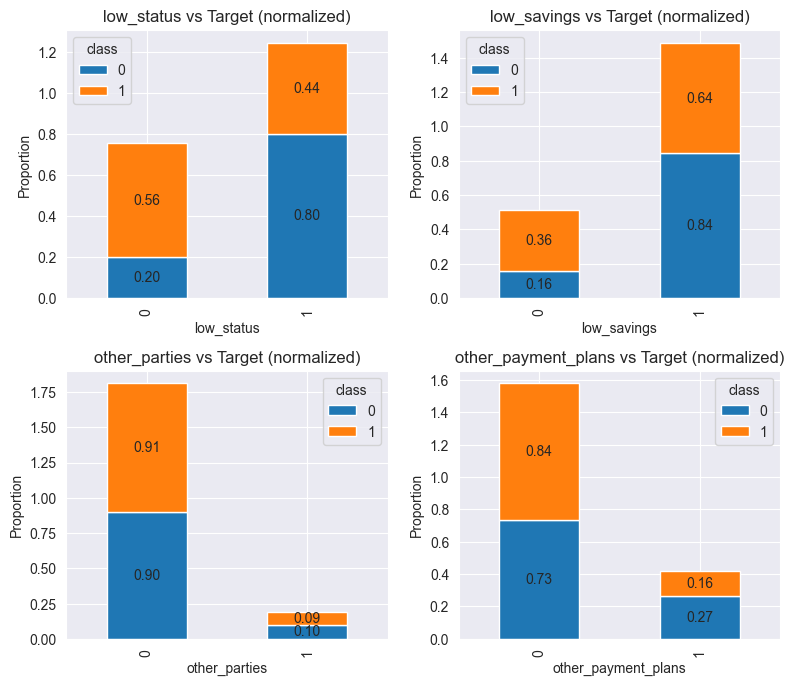

In [17]:
test_columns = ['low_status', 'low_savings', 'other_parties', 'other_payment_plans']
plot_dashboard(data=data, columns=test_columns, rows=3, cols=2, figsize=(8, 10))

In [18]:
num_cols2 = ['installment_commitment', 'residence_since', 'existing_credits', 
             'num_dependents', 'own_telephone', 'foreign_worker']

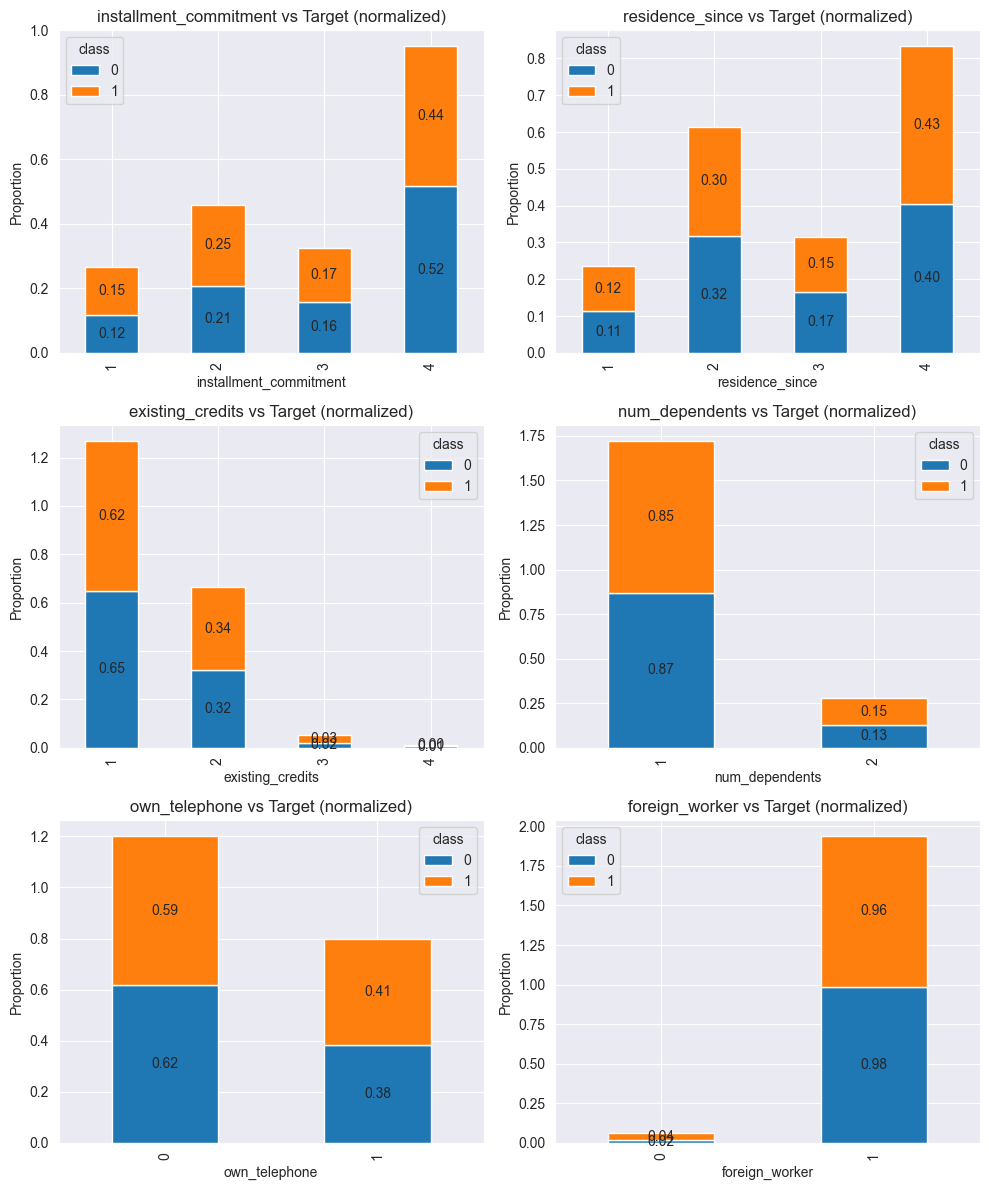

In [19]:
plot_dashboard(data=data, columns=num_cols2, rows=3, cols=2, figsize=(10, 12))

In [20]:
def is_installment_low(x: int):
    if x <= 2:
        return 1
    return 0


def is_residence_low(x: int):
    if x <= 2:
        return 1
    return 0

 - Особых различий в распределениях нет. 
Возможно, в будущем можно попробовать объединить некоторые значения по группам и тогда посмотреть на их влияние. Например, объединить installment_commitment на две группы: 1-2 и 3-4.
 - foreign_worker выглядит неинформативным признаком

In [21]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(
    go.Box(x=data['class'], y=data['duration'], name='duration'), row=1, col=1)
fig.add_trace(
    go.Box(x=data['class'], y=data['credit_amount'], name='credit amount'), row=1, col=2)
fig.add_trace(
    go.Box(x=data['class'], y=data['age'], name='age'), row=2, col=1)

fig.update_layout(
    title='Зависимость между числовыми признаками и таргетом',
    template='plotly_dark',
)

fig.show()

Признаки <b>duration</b> и <b>credit_amount</b> могут оказаться более значимыми для разделения классов из-за различий в распределении.
Попробуем очистить данные от выбросов с помощью межквартильного размаха и посмотрим на распределение

<font size=5>Очистка от выбросов</font>

In [44]:
def set_border(df: pd.DataFrame, column: str) -> tuple[float, float]:
    """
    Функция для установки границ по межквартильному размаху;
    :param df: набор данных;
    :param column: название признака;
    :return: границе по левой и правой стороне.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1

    left_border = round(q1 - 1.5 * iqr, 2)
    right_border = round(q3 + 1.5 * iqr, 2)

    if left_border < df[column].min():
        left_border = df[column].min()

    if right_border > df[column].max():
        right_border = df[column].max()

    return left_border, right_border

In [45]:
emissions_cols = ['duration', 'credit_amount', 'age']

In [46]:
n = data.shape[0]
clear_data = data.copy()
for col in emissions_cols:
    left, right = set_border(df=data, column=col)
    clear_data = clear_data.query(f'{left} <= {col} <= {right}')
print(f'удалено: {n - clear_data.shape[0]} точек')

удалено: 100 точек


In [47]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Box(x=clear_data['class'], y=clear_data['credit_amount'], name='credit_amount'), row=1, col=1)
fig.add_trace(
    go.Box(x=clear_data['class'], y=clear_data['duration'], name='duration'), row=2, col=1)
fig.add_trace(
    go.Box(x=clear_data['class'], y=clear_data['age'], name='age'), row=3, col=1)


fig.update_layout(
    title='Зависимость между числовыми признаками таргетом',
    template='plotly_dark',
)

fig.show()

duration отличается у класса 0 и 1, а credit_amount примерно стал равным

<font size=5>Матрица корреляции</font>

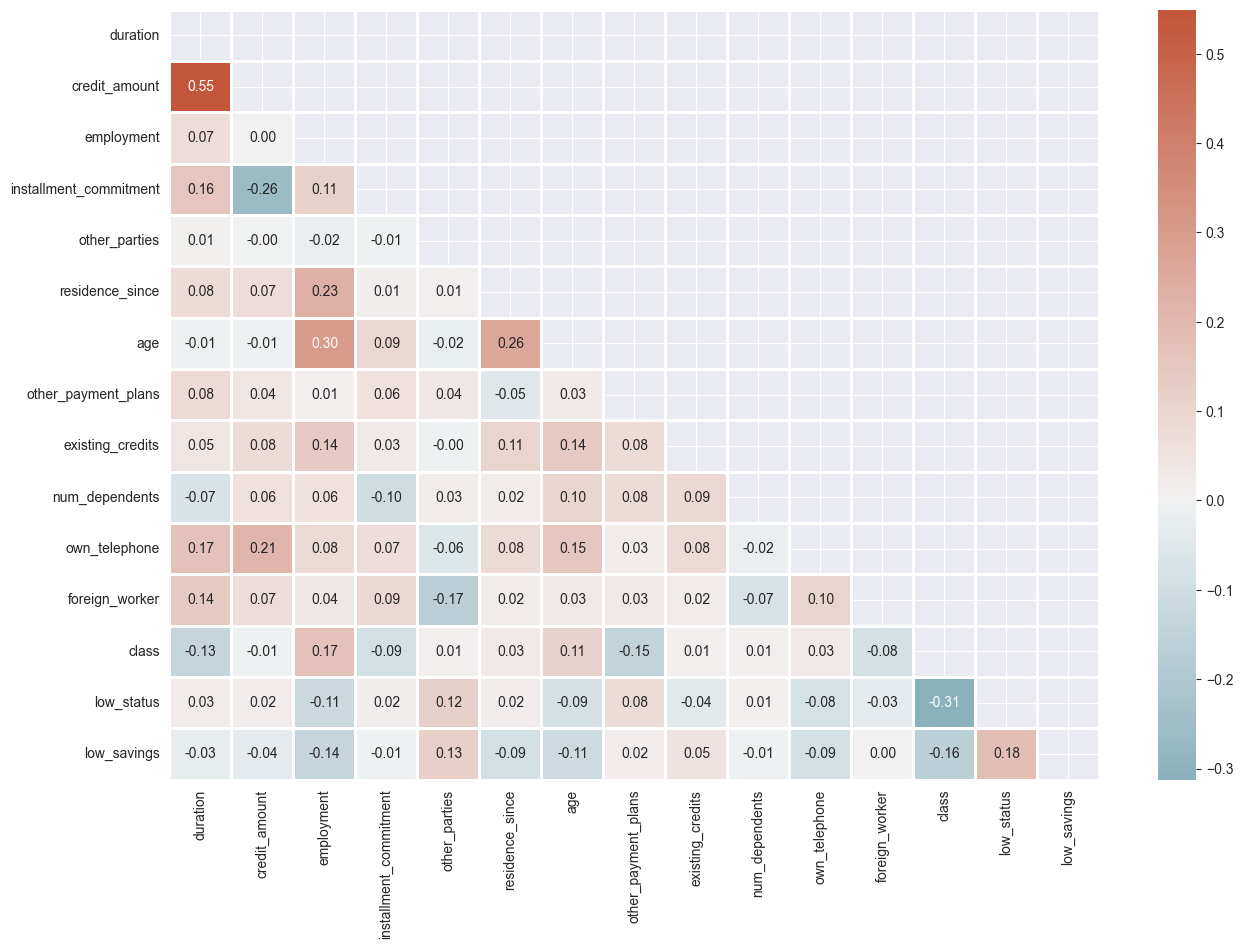

In [48]:
numeric_cols = clear_data.select_dtypes(np.number)
plt.figure(figsize=(15,10))
corr = numeric_cols.corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot = True, fmt='.2f', mask=mask,
            center=0, cmap=cmap, linewidths=1)

plt.show()

Выводы по EDA:
 - Потенциально важные признаки: checking_status, credit_history (по логике), savings_status, employment (тоже по логике должен влиять на таргет), housing (наличие собственного жилья должно говорить о фин. возможностях клиента), other_parties (по идеи тоже должен вляить на таргет, но признак имеет сильный дисбаланс)
  - С помощью матрицы корреляции можно заметить зависимость между duration и credit_amount, что по сути логично, чем больше сумма кредита, тем больше срок. Зависимость с коэффициентом 0.54 - не самая высокая, но чтобы избежать мультиколлинеарности будем использовать регуляризацию.
  - С таргетом коррелируют признаки employment, age, duration (отрицательно), other_payment_plans (отрицательно), low_status (отрицательно), low_savings.

<font size=6>Прогнозирование Рисков</font>

<font size=5>Обработка данных</font>

Стандартизируем числовые данные, а категориальные закодируем через OneHotEncoding

In [49]:
X = clear_data.drop(['class'], axis=1)
y = clear_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

Протестировав разные комбинации признаков, я попробовал избавиться от шумных данных и оставил такой набор:

In [50]:
categorical_cols = X.select_dtypes('object').columns
numeric_cols = ['duration', 'credit_amount', 'employment', 'existing_credits']
binary_cols = ['other_payment_plans', 'low_status', 'low_savings', 'other_parties']

In [51]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('bin', 'passthrough', binary_cols)
    ]
)

In [52]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

<font size=5>Logistic Regression</font>

In [53]:
param_dist = {
    'model__solver': ['newton-cg', '1bfgs', 'liblinear'],
    'model__penalty': ['l1', 'l2'],
    'model__C': [100, 10, 1.0, 0.1, 0.01],
    'model__max_iter': [int(x) for x in np.linspace(start=50, stop=500, num=10)],
    'model__fit_intercept': [True, False]
}

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

rs_lr = RandomizedSearchCV(lr_pipeline,
                           param_distributions=param_dist,
                           n_iter=100,
                           cv=5, 
                           verbose=1,
                           n_jobs=-1,
                           random_state=42)
rs_lr.fit(X_train, y_train)
rs_lr.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'model__solver': 'liblinear',
 'model__penalty': 'l1',
 'model__max_iter': 300,
 'model__fit_intercept': False,
 'model__C': 10}

<font size=4>Оценка Logistic Regression</font>

In [54]:
rs_lr_predict = rs_lr.best_estimator_.predict(X_test)
print(classification_report(y_test, rs_lr_predict))
print(f1_score(y_test, rs_lr_predict))
print(roc_auc_score(y_test, rs_lr_predict))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        38
           1       0.84      0.91      0.87       102

    accuracy                           0.81       140
   macro avg       0.76      0.72      0.74       140
weighted avg       0.80      0.81      0.80       140

0.8732394366197183
0.7190402476780187


In [55]:
lr_pipeline.fit(X_train, y_train)
lr_predict = lr_pipeline.predict(X_test)

coefficients = lr_pipeline.named_steps['model'].coef_.flatten()
categorical_feature_names = list(lr_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols))
feature_names = numeric_cols + categorical_feature_names + binary_cols
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})


fig = px.bar(coef_df.sort_values(by='Coefficient', ascending=False),
             x='Coefficient', y='Feature', orientation='h',
             color='Coefficient', color_continuous_scale='blues')

fig.update_layout(
    title='Веса признаков Логистической Регрессии',
    font=dict(
        family='Verdana',
        size=13,
    ),
    autosize=False,
    width=800,
    height=500
)

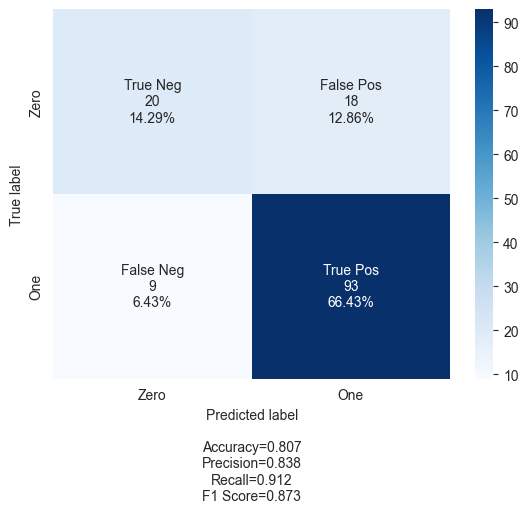

In [56]:
cf_matrix = confusion_matrix(y_test, rs_lr_predict)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

<font size=5>Random Forest</font>

In [57]:
param_dist = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__max_depth': [10, 20, 30, 40, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}


rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])


rs_forest = RandomizedSearchCV(estimator=rf_pipeline,
                               param_distributions=param_dist,
                               n_iter=100,
                               cv=5,  
                               verbose=1,
                               n_jobs=-1,
                               random_state=42)
rs_forest.fit(X_train, y_train)
rs_forest.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'model__n_estimators': 100,
 'model__min_samples_split': 2,
 'model__min_samples_leaf': 1,
 'model__max_depth': None,
 'model__bootstrap': True}

<font size=4>Оценка Random Forest</font>

In [58]:
rs_forest_predict = rs_forest.best_estimator_.predict(X_test)
print(classification_report(y_test, rs_forest_predict))
print(f1_score(y_test, rs_forest_predict))
print(roc_auc_score(y_test, rs_forest_predict))

              precision    recall  f1-score   support

           0       0.52      0.34      0.41        38
           1       0.78      0.88      0.83       102

    accuracy                           0.74       140
   macro avg       0.65      0.61      0.62       140
weighted avg       0.71      0.74      0.72       140

0.8294930875576036
0.6122291021671826


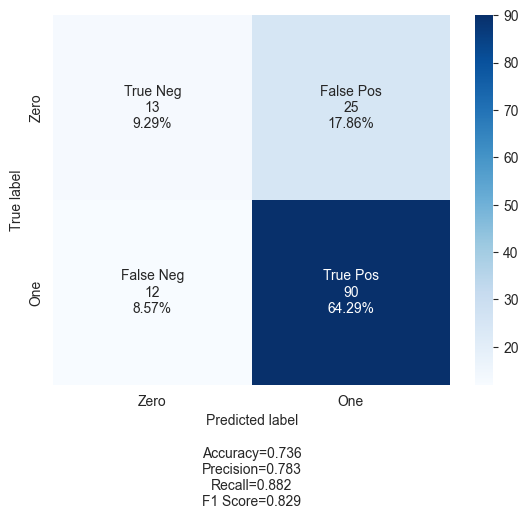

In [59]:
cf_matrix = confusion_matrix(y_test, rs_forest_predict)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

<font size=5>Gradient Boosting</font>

In [60]:
param_dist = {
    'model__n_estimators': [100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.1, 0.05, 0.001],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__max_features': ['auto', 'sqrt', 'log2', None]
}


gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())
])


rs_gb = RandomizedSearchCV(estimator=gb_pipeline,
                               param_distributions=param_dist,
                               n_iter=100,
                               cv=5,
                               verbose=1,
                               n_jobs=-1,
                               random_state=42)
rs_gb.fit(X_train, y_train)
rs_gb.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'model__subsample': 0.8,
 'model__n_estimators': 200,
 'model__min_samples_split': 5,
 'model__min_samples_leaf': 4,
 'model__max_features': 'log2',
 'model__max_depth': 4,
 'model__learning_rate': 0.1}

<font size=4>Оценка Gradient Boosting</font>

In [61]:
rs_gb_predict = rs_gb.best_estimator_.predict(X_test)
print(classification_report(y_test, rs_gb_predict))
print(f1_score(y_test, rs_gb_predict))
print(roc_auc_score(y_test, rs_gb_predict))

              precision    recall  f1-score   support

           0       0.46      0.34      0.39        38
           1       0.78      0.85      0.81       102

    accuracy                           0.71       140
   macro avg       0.62      0.60      0.60       140
weighted avg       0.69      0.71      0.70       140

0.8130841121495327
0.5975232198142415


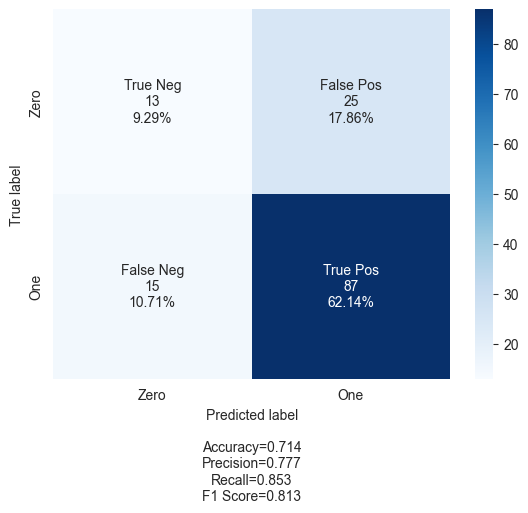

In [62]:
cf_matrix = confusion_matrix(y_test, rs_gb_predict)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

<font size=6>Выводы.</font>

<br><br>
<font size=5>Модель:</font>
 - Лучший результат показала Logistic Regression c подбором гиперпараметров.
 - Предсказания по классу 1 имеют хорошие оценки f1 = 0.87
 - Предсказания по классу 0 делаются хуже, удалось добиться f1 = 0.6, при precision = 0.69, recall = 0.53. Также удалось снизить FalsePositive до 12%

<font size=5>Данные:</font>
 - Данных по 0 классу в принципе оказалось мало, но кроме этого мало признаков (значений), которые явно бы отличали один класс от другого. Большинство значений можно применить для обоих классов. Это можно заметить на этапе EDA, где признаки казались шумными. 
 - Стоит продолжать дополнять данные.
 - В качестве дополнительных признаков я бы посоветовал добавить: уровень образования, сколько времени человек является клиентом банка, уровень дохода, регион проживания, частота подачи заявок на кредит, 